In [ ]:
# %pip install scanpy

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
adata1 = sc.read(r'dataset_extracted/GSM5201883/matrix.mtx.gz', cache=True).transpose()
adata1.var_names = pd.read_csv(r'dataset_extracted/GSM5201883/features.tsv.gz', header=None, sep='\t')[1]
adata1.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201883/barcodes.tsv.gz', header=None)[0])

In [3]:
adata1

AnnData object with n_obs × n_vars = 5538 × 33538

In [4]:
adata2 = sc.read(r'dataset_extracted/GSM5201884/matrix.mtx.gz', cache=True).transpose()
adata2.var_names = pd.read_csv(r'dataset_extracted/GSM5201884/features.tsv.gz', header=None, sep='\t')[1]
adata2.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201884/barcodes.tsv.gz', header=None)[0])

In [5]:
adata2

AnnData object with n_obs × n_vars = 10756 × 33538

In [6]:
adata3 = sc.read(r'dataset_extracted/GSM5201885/matrix.mtx.gz', cache=True).transpose()
adata3.var_names = pd.read_csv(r'dataset_extracted/GSM5201885/features.tsv.gz', header=None, sep='\t')[1]
adata3.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201885/barcodes.tsv.gz', header=None)[0])

In [7]:
adata3

AnnData object with n_obs × n_vars = 6753 × 33538

In [8]:
adata4 = sc.read(r'dataset_extracted/GSM5201886/matrix.mtx.gz', cache=True).transpose()
adata4.var_names = pd.read_csv(r'dataset_extracted/GSM5201886/features.tsv.gz', header=None, sep='\t')[1]
adata4.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201886/barcodes.tsv.gz', header=None)[0])

In [9]:
adata4

AnnData object with n_obs × n_vars = 9676 × 33538

In [10]:

# matrix file has row and column names, so remove them:
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
adata4.var_names_make_unique()

In [11]:
adata_list = [adata1, adata2, adata3, adata4]
adata_merged = ad.AnnData.concatenate(*adata_list, join='outer')


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [12]:

adata_merged.obs_names = pd.concat([pd.Series(adata1.obs_names), 
                              pd.Series(adata2.obs_names), 
                              pd.Series(adata3.obs_names), 
                              pd.Series(adata4.obs_names)], join='outer')


In [13]:
adata_merged.var_names = adata1.var_names

In [14]:
adata_merged.obs_names_make_unique()


In [15]:
adata = adata_merged

# DATA PREPROCESSING 

### Show those genes that yield the highest fraction of counts in each single cell, across all cells



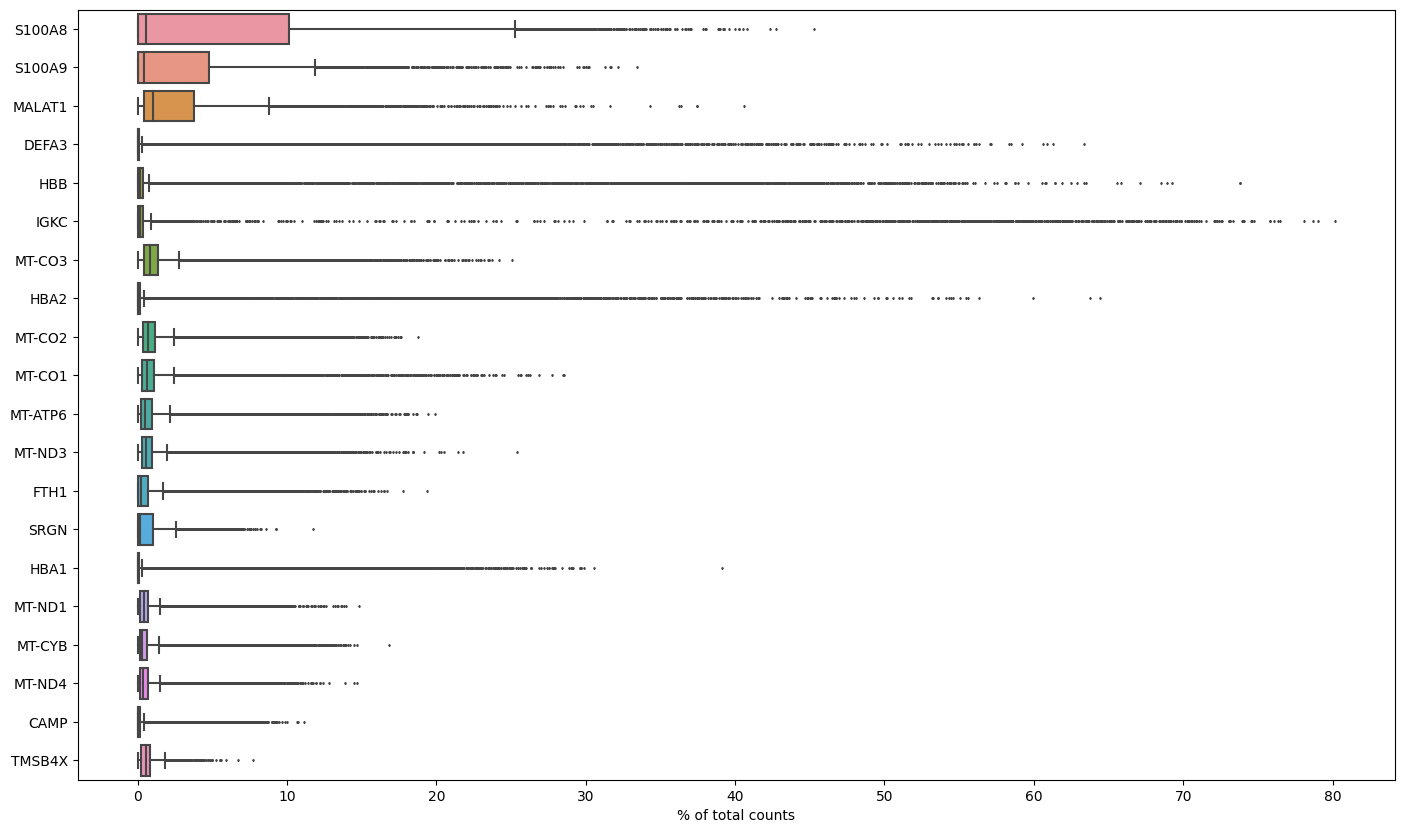

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20, show=False)
fig = plt.gcf()
fig.set_size_inches(17, 10)

plt.show()

### Filtering out genes that are detected in less than 3 cells

In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_cells(adata, min_counts=1)

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [ ]:
%pip install leidenalg

## Genes to be considered according to https://academic.oup.com/ndt/article/29/suppl_4/iv55/1908818:
startswith:
- PTH
- CYP27A1
- CYP2R1
- CYP27B1
- FGF23
- VDR
- GATA3
- CARS
- DGKD
- DGKH
- NADSYN1
- GC
- DHCR7
- 

Genes Not effecting according to the paper, but are related to calcium synthesis:
- TRPV5
- TRPV6
- ATP2B1
- SLC8A1

In [ ]:
truth_array = adata.var_names.str.startswith(genes_list[0])
for gene in genes_list[1:]:
    truth_array += adata.var_names.str.startswith(gene)

### Number of genes considered:

In [ ]:
c=0
for i in truth_array:
    if i ==True:
        c+=1
print(c)

In [ ]:
adata.var['ca'] = truth_array  # annotate the group of calcium-related genes as 'ca'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ca'], percent_top=None, log1p=False, inplace=True)


**Violin plots** of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in calcium-related genes

In [ ]:
# NOT WORKING WITHOUT CA GENES - acronym: NA
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ca'],
             jitter=0.4, multi_panel=True)

### Remove cells that have too many calcium genes expressed or too many total counts:



In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ca')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_ca < 5, :]

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)


In [19]:
# Logarithmize the data:
sc.pp.log1p(adata)


### Identify highly-variable genes

In [22]:
# NA
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)


In [21]:
# sc.pp.highly_variable_genes(adata)


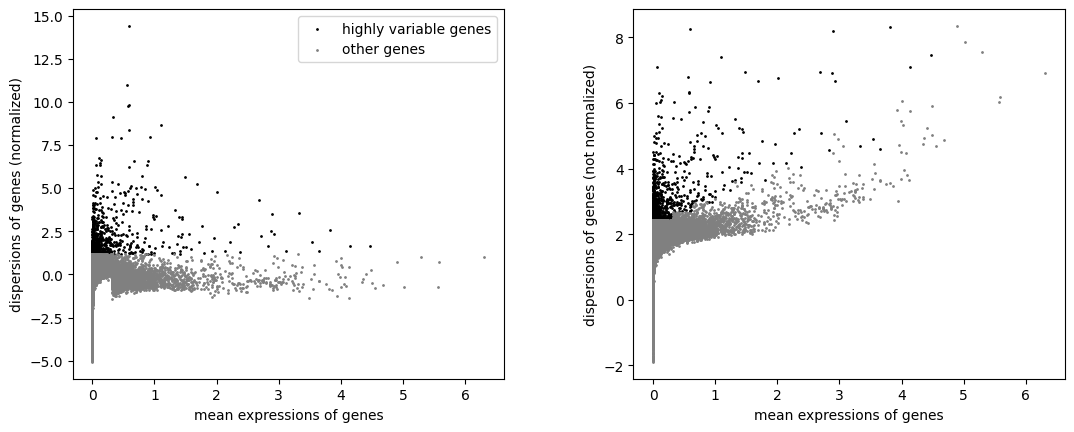

In [22]:
sc.pl.highly_variable_genes(adata)


In [27]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)


In [35]:
print(adata.obs.columns)
# print(adata.obs.index)


Index(['batch', 'n_genes'], dtype='object')


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
sc.tl.rank_genes_groups(adata, 'batch', method='wilcoxon')


KeyboardInterrupt: 

In [37]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata


In [38]:
# Filtering:
adata = adata[:, adata.var.highly_variable]


In [39]:
#Regress out effects of total counts per cell and the percentage of calcium genes expressed. Scaling the data to unit variance.

# NA
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_ca'])


KeyError: "None of [Index(['total_counts', 'pct_counts_ca'], dtype='object')] are in the [columns]"

In [23]:
# Scaling each gene to unit variance. Clipping values exceeding standard deviation 10:

sc.pp.scale(adata, max_value=10)


# PRINCIPLE COMPONENT ANALYSIS

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [25]:
sc.tl.pca(adata, svd_solver='arpack')


In [42]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)


In [43]:
sc.tl.leiden(adata, resolution=0.5)


In [44]:
sc.tl.umap(adata)


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


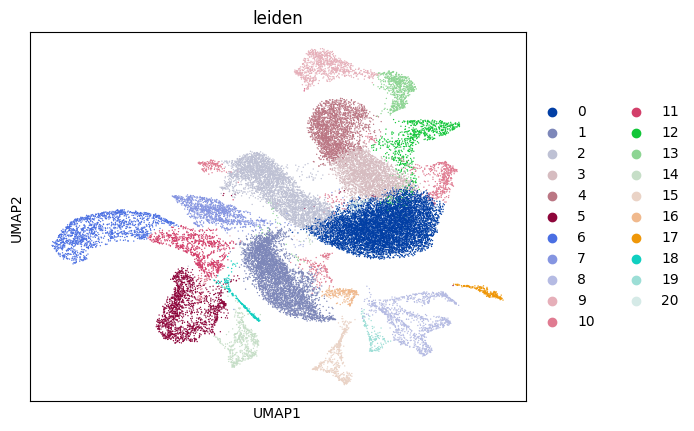

In [46]:
sc.pl.umap(adata, color=['leiden'], cmap='viridis')


## Scatter Plot

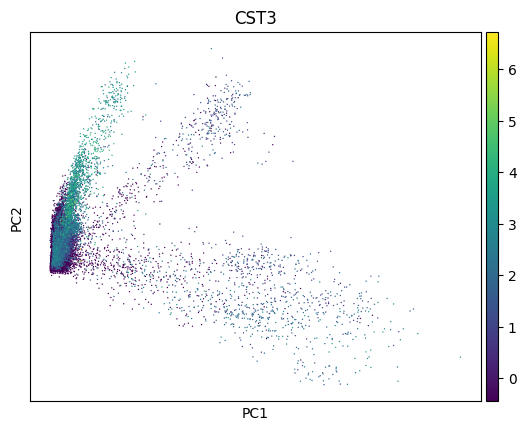

In [26]:
sc.pl.pca(adata, color='CST3')


## Inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). (Often a rough estimate of the number of PCs works).

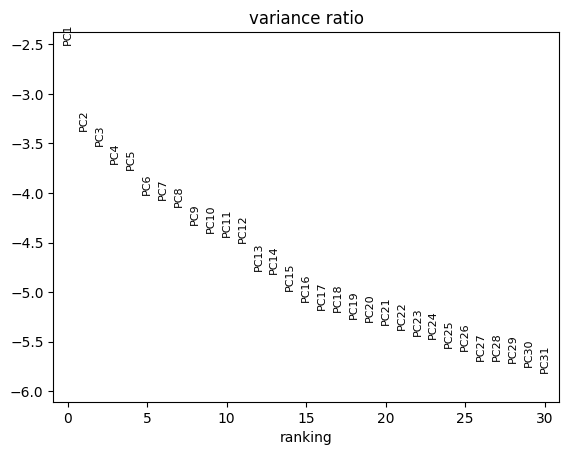

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)


In [ ]:
adata.write("results_file.h5ad")


In [ ]:
adata

## Computing the Neighbourhood Graph

In [45]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)


## Embedding the neighborhood graph


Embedding the graph in two dimensions using UMAP (McInnes et al., 2018). 
It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [ ]:
# pip install leidenalg

In [46]:
sc.tl.leiden(adata)

In [47]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [31]:
sc.tl.umap(adata)


In [ ]:
genes_list

In [ ]:
### Note: last 4 in genes_list are proposed to not effect calcium homeostasis according to the paper

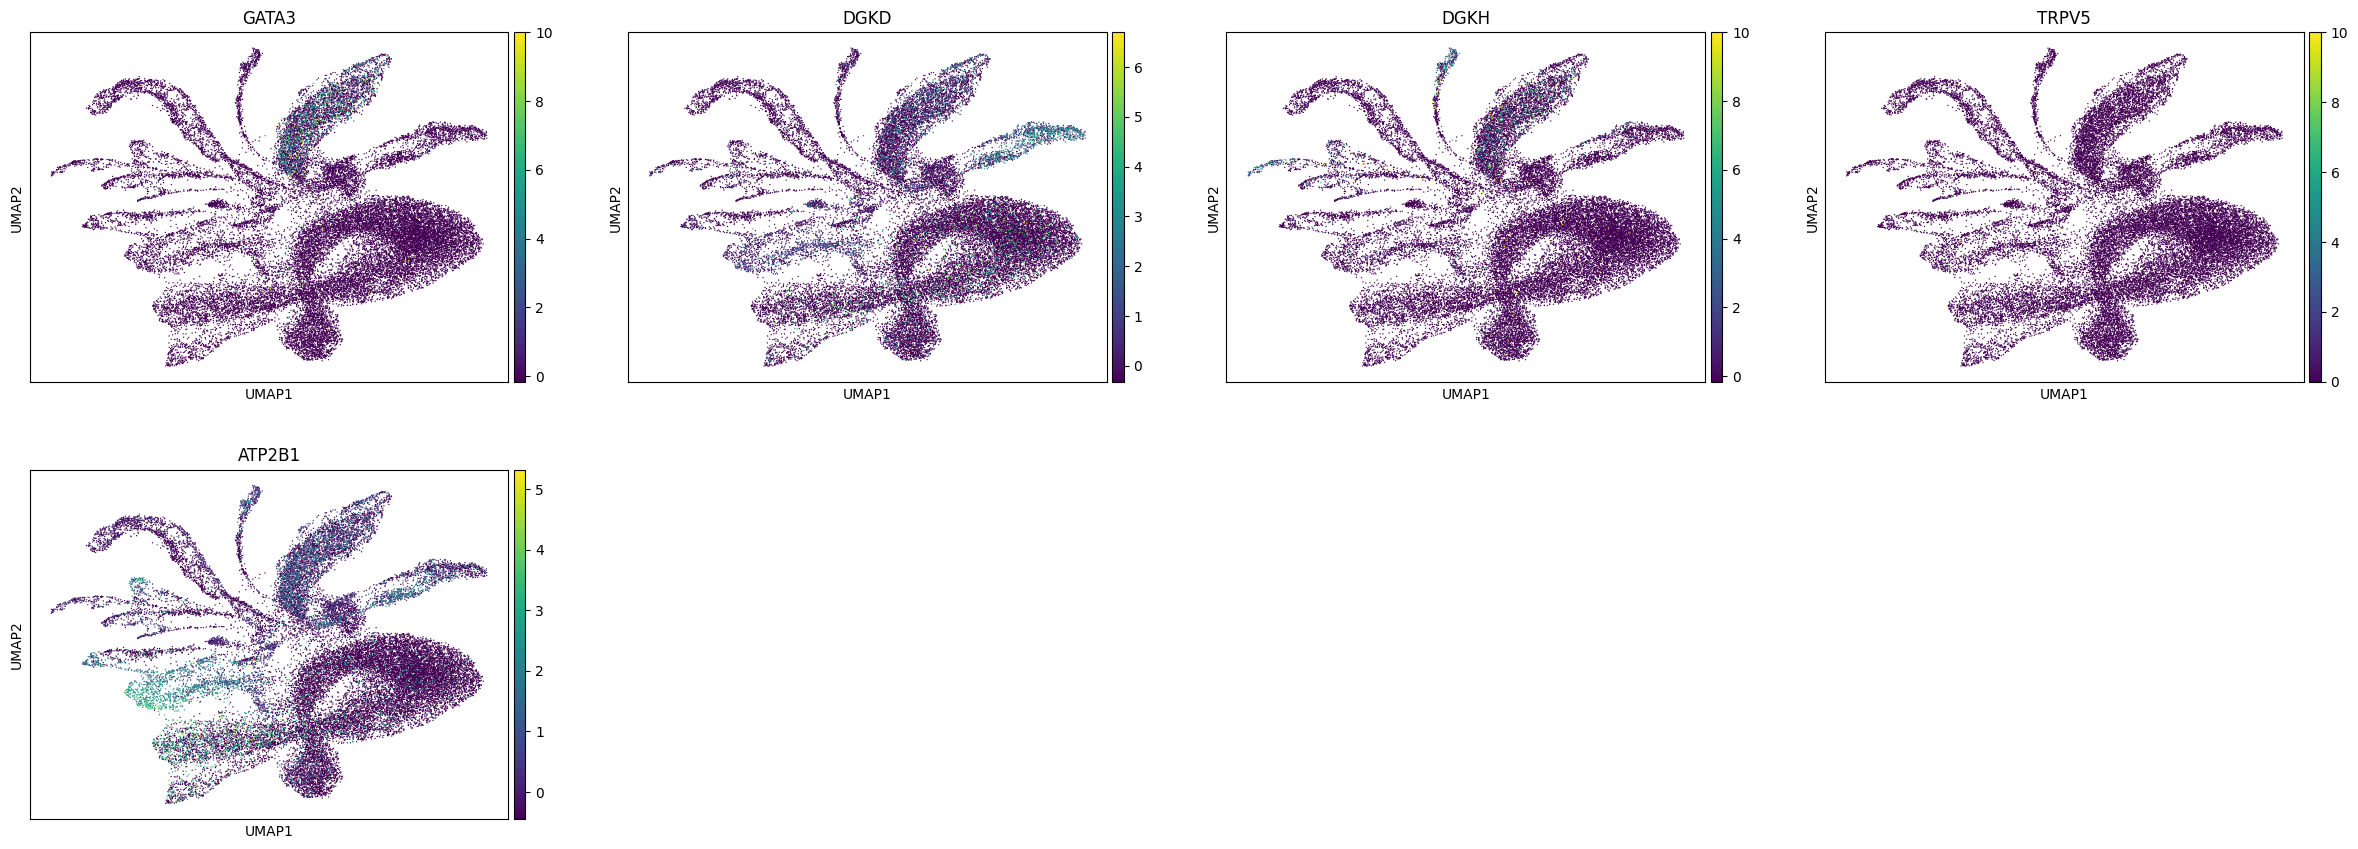

In [48]:
sc.pl.umap(adata, color=['GATA3','DGKD','DGKH','TRPV5', 'ATP2B1'])


### Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.


In [49]:
sc.tl.leiden(adata)


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


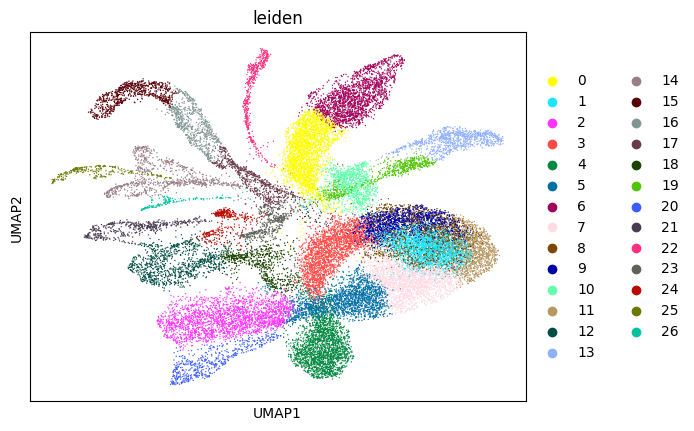

In [50]:
sc.pl.umap(adata, color=['leiden'])


In [ ]:
adata.write("results_file.h5ad")


## Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the **t-test**.

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

KeyboardInterrupt: 

In [66]:
print((adata.uns['rank_genes_groups']['names'][10]))


('PGLYRP1', 'CEACAM8', 'PGLYRP1', 'RPS6', 'RPS18', 'HLA-A', 'H3F3A', 'SOD2', 'RNASE2', 'RPS16', 'SPCS2', 'YBX1', 'CEACAM8', 'TPM1', 'G0S2', 'LTF', 'S100P', 'PRDX2', 'YBX3', 'RPL13', 'CD74', 'CAVIN1', 'RPL29', 'RPL15', 'TMCC2', 'TPM2', 'RPS27A', 'PLD4', 'LMO4', 'RPS3A', 'CEACAM8', 'RPS3', 'FGFBP2', 'MYL6')


In [85]:
# get list of differentially expressed genes
de_genes = adata.uns['rank_genes_groups']['names'][:1000]
gs = []
for i in de_genes:
    for j in i:
        gs.append(j)

# print(gs)

In [86]:

# filter genes that are known to be involved in calcium signaling
key_genes = [gene for gene in gs if gene in genes_list]
print(key_genes)

['ATP2B1', 'ATP2B1', 'ATP2B1', 'ATP2B1', 'DGKD', 'ATP2B1', 'DHCR7', 'DGKD', 'VDR', 'VDR', 'GATA3', 'SLC8A1', 'SLC8A1', 'DGKH', 'DGKH', 'ATP2B1', 'SLC8A1', 'GATA3', 'DHCR7', 'CYP27A1', 'DGKD', 'NADSYN1', 'DHCR7', 'DHCR7', 'VDR', 'DHCR7', 'GATA3', 'GATA3']


In [87]:
print(dict(key_genes))

ValueError: dictionary update sequence element #0 has length 6; 2 is required

### result of a Wilcoxon rank-sum (Mann-Whitney-U) test:

In [51]:
sc.settings.verbosity = 2  # reduce the verbosity


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


In [ ]:
adata.write("results_file.h5ad")


### Rank genes using logistic regression
The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')


In [40]:
genes_list = ["PTH", "CYP27A1", "CYP2R1", "CYP27B1", "FGF23", "VDR", "GATA3", "CARS", "DGKD", "DGKH", "NADSYN1", "GC", "DHCR7",
             "TRPV5", "TRPV6", "ATP2B1", "SLC8A1"]

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read("results_file.h5ad")


In [36]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,LCN2,LTF,S100A12,AZU1,RPS27,CCL5,NAMPT,FTH1,DEFA3,LGALS1,...,HBA2,ADIRF,NKG7,PLD4,CPA3,DNTT,XPO7,MT1X,FN1,S100A8
1,LTF,RETN,MMP9,MPO,RPL10,IL32,FTH1,CXCL8,BPI,CST3,...,HBA1,TAGLN,GZMB,IRF8,HDC,VPREB1,RETN,MT2A,DCN,LTF
2,CAMP,CAMP,S100A8,ELANE,IL7R,DUSP2,CXCL8,NAMPT,DEFA4,ANXA2,...,HBB,MYL9,GZMH,C12orf75,GATA2,TCF4,CYBB,MT1E,C2orf40,LCN2
3,S100A9,LCN2,S100A9,PRTN3,RPL30,GZMK,S100A6,G0S2,SRGN,LYZ,...,TMCC2,CALD1,FGFBP2,SEC61B,BIRC3,SOX4,LCN2,IL32,BGN,CAMP
4,S100A8,LYZ,S100A6,CTSG,IL32,B2M,G0S2,NEAT1,CD24,TMSB10,...,SLC4A1,IGFBP7,B2M,CCDC50,TPSB2,IGLL1,MYL6,RPS27,MT2A,S100A9


In [41]:
pd.set_option('display.max_columns', None)


In [44]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p,17_n,17_p,18_n,18_p,19_n,19_p,20_n,20_p,21_n,21_p,22_n,22_p,23_n,23_p,24_n,24_p,25_n,25_p,26_n,26_p,27_n,27_p,28_n,28_p,29_n,29_p,30_n,30_p,31_n,31_p,32_n,32_p,33_n,33_p
0,LCN2,0.0,LTF,0.0,S100A12,0.0,AZU1,0.0,RPS27,0.0,CCL5,0.0,NAMPT,0.0,FTH1,0.0,DEFA3,0.000000e+00,LGALS1,0.0,MZB1,0.0,HBB,0.0,DEFA3,0.000000e+00,COL1A2,3.567694e-301,MNDA,1.866389e-286,HMGN2,2.682547e-301,HSPA1A,0.000000e+00,HBM,0.0,CD79B,0.0,CD74,0.0,FTL,3.638428e-293,IFI27,3.912359e-212,RPS2,2.404402e-156,HLA-DRA,3.044973e-167,HBA2,1.893384e-167,ADIRF,2.105909e-163,NKG7,5.691899e-154,PLD4,8.575549e-141,CPA3,1.354637e-92,DNTT,5.944081e-100,XPO7,2.326195e-58,MT1X,3.432795e-90,FN1,3.834519e-87,S100A8,2.927564e-26
1,LTF,0.0,RETN,0.0,MMP9,0.0,MPO,0.0,RPL10,0.0,IL32,0.0,FTH1,0.0,CXCL8,0.0,BPI,0.000000e+00,CST3,0.0,SSR4,0.0,AHSP,0.0,BPI,0.000000e+00,IFITM3,2.734777e-286,ISG15,9.353408e-256,TOP2A,1.143049e-234,DNAJB1,0.000000e+00,AHSP,0.0,IGHM,0.0,HLA-DRA,0.0,SELENOP,3.890338e-281,GNG11,5.600594e-198,RPS4X,4.682790e-156,HLA-DPA1,9.852129e-167,HBA1,5.870547e-167,TAGLN,2.165492e-160,GZMB,3.642255e-145,IRF8,2.473304e-139,HDC,8.107091e-77,VPREB1,5.060744e-89,RETN,2.147891e-33,MT2A,9.521112e-89,DCN,2.836861e-84,LTF,2.197939e-24
2,CAMP,0.0,CAMP,0.0,S100A8,0.0,ELANE,0.0,IL7R,0.0,DUSP2,0.0,CXCL8,0.0,NAMPT,0.0,DEFA4,0.000000e+00,ANXA2,0.0,SEC11C,0.0,HBA1,0.0,DEFA4,0.000000e+00,DCN,1.775942e-285,IFIT3,4.279296e-253,CD24,4.287753e-207,HSP90AA1,1.299038e-302,SLC4A1,0.0,TCL1A,0.0,MS4A1,0.0,C1QA,1.628591e-262,FABP4,1.586259e-184,NPM1,6.044861e-154,HLA-DRB1,9.426831e-166,HBB,1.193519e-166,MYL9,6.922952e-146,GZMH,1.094125e-140,C12orf75,3.272349e-139,GATA2,6.458218e-74,TCF4,3.066070e-87,CYBB,9.544001e-31,MT1E,2.918707e-66,C2orf40,5.897378e-76,LCN2,6.274590e-24
3,S100A9,0.0,LCN2,0.0,S100A9,0.0,PRTN3,0.0,RPL30,0.0,GZMK,0.0,S100A6,0.0,G0S2,0.0,SRGN,1.561957e-274,LYZ,0.0,FKBP11,0.0,HBD,0.0,SRGN,5.301857e-265,CALD1,2.180303e-281,FCGR3B,5.332187e-238,DEFA3,1.436148e-198,HSPA1B,1.262568e-301,HBD,0.0,PCDH9,0.0,CD79A,0.0,CST3,1.892973e-254,SPARCL1,6.366957e-184,RPL15,1.119477e-153,HLA-DPB1,3.259289e-165,TMCC2,5.698591e-165,CALD1,2.316832e-144,FGFBP2,3.446366e-130,SEC61B,6.492575e-138,BIRC3,3.979527e-69,SOX4,6.928843e-82,LCN2,1.264827e-29,IL32,9.871868e-61,BGN,2.414797e-69,CAMP,1.686485e-22
4,S100A8,0.0,LYZ,0.0,S100A6,0.0,CTSG,0.0,IL32,0.0,B2M,0.0,G0S2,0.0,NEAT1,0.0,CD24,2.675436e-268,TMSB10,0.0,DERL3,0.0,PRDX2,0.0,MS4A3,2.364154e-233,LGALS1,9.449893e-248,SAT1,1.207175e-235,BPI,3.648179e-181,HSPH1,5.705521e-230,GYPA,0.0,VPREB3,0.0,HLA-DRB1,0.0,C1QB,3.874332e-252,TM4SF1,6.449676e-184,EEF1B2,6.227484e-152,CST3,1.632299e-162,SLC4A1,6.689879e-164,IGFBP7,1.082920e-143,B2M,1.705677e-126,CCDC50,1.925315e-137,TPSB2,3.490318e-67,IGLL1,5.030888e-81,MYL6,2.522168e-29,RPS27,6.791221e-60,MT2A,7.062568e-69,S100A9,3.916036e-22


C:\Users\rahvk\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


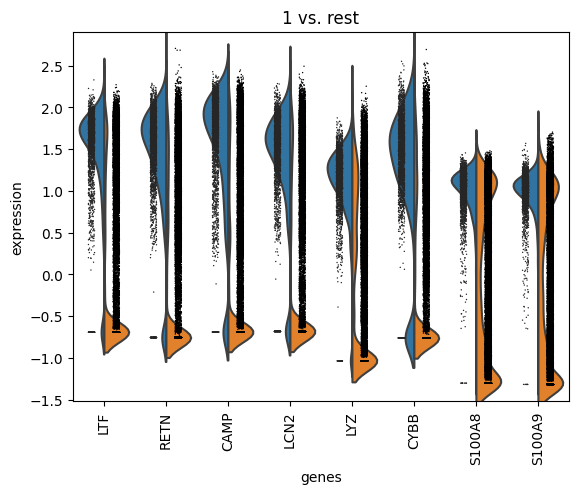

In [39]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=8)


In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')
